In [21]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

In [26]:
import os
print(os.getcwd())

/home/jovyan/work


In [27]:
folder_path = 'data/4'

In [28]:
def from_json_folder_to_json_docs(folder_path):
    pathlist = Path(folder_path).glob('**/*.json')
    json_docs = []
    for path in pathlist:
        # because path is object not string
        path_in_str = str(path)
        print('processing file: ' + path_in_str)
        with open(path_in_str, encoding="utf8") as f:
            json_file = json.load(f)
            json_docs.append(json_file)
    print('Done!')
    return json_docs

In [29]:
json_data = from_json_folder_to_json_docs(folder_path)

processing file: data/4/1-10.json
processing file: data/4/11-20.json
processing file: data/4/21-30.json
Done!


In [30]:
first_it = True
for json in json_data:
    #print(json.keys())
    if first_it != True:
        alerts_df.append(pd.DataFrame(json['alerts']), ignore_index=True)
        jams_df.append(pd.DataFrame(json['jams']), ignore_index=True)
    else:
        alerts_df = pd.DataFrame(json['alerts'])
        jams_df = pd.DataFrame(json['jams'])
        first_it = False

In [31]:
del json_data

In [32]:
alerts_df.head(3)

,uuid,alert_type_id,alert_subtype_id,country,report_rating,confidence,reliability,magvar,location,publish_date,last_seen,city,road_type,street,report_description,thumbs_up,report_by_partner,jam_uuid
0,8271e6bf-fca0-3cad-bac4-6a6959d16b1c,4,13.0,CI,0,5,10,265,"[-70.646227, -33.635035]",2018-04-01T01:02:02+00:00,2018-04-01T03:00:21+00:00,None,3.0,Ruta 79,None,0,None,None
1,e7b8841f-a144-3b7d-b685-05bc447b73fd,3,4.0,CI,1,0,5,56,"[-70.670608, -33.398605]",2018-04-01T02:30:58+00:00,2018-04-01T03:00:21+00:00,Conchalí,2.0,Av. Dorsal,None,0,None,None
2,e1c149d5-4383-3490-bb2d-550156e3ad51,3,3.0,CI,1,0,5,2,"[-70.575705, -33.469535]",2018-04-01T02:31:00+00:00,2018-04-01T03:00:21+00:00,Ñuñoa,2.0,None,None,0,None,None


In [33]:
alerts_df.shape

(115547, 18)

In [34]:
# parse date to datetime object
alerts_df['publish_date_dt'] = pd.to_datetime(alerts_df['publish_date'])

In [35]:
# subsets dataframe
alerts_df.drop(alerts_df.columns.difference(['alert_subtype_id', 'alert_type_id', 'street', 'publish_date_dt']), 1, inplace=True)

In [36]:
# drop duplicates
alerts_df.drop_duplicates(inplace=True)

In [37]:
# drop nans from alert_subtype_id, street
alerts_df.dropna(subset=['alert_subtype_id','street'], inplace=True)

In [38]:
# sort by date just in case
alerts_df.sort_values(by=['publish_date_dt'], inplace = True)

In [39]:
# set date as index, not sure if good idea
#alerts_df = alerts_df.set_index('publish_date_dt').sort_index()

In [40]:
alerts_df.head(3)

,alert_type_id,alert_subtype_id,street,publish_date_dt
115496,4,7.0,Alberto Llona,2016-08-06 17:55:23+00:00
115542,4,7.0,Manuel Antonio Matta,2017-01-14 15:01:37+00:00
115497,4,7.0,Manuel Antonio Matta,2017-01-14 16:01:37+00:00


In [41]:
alerts_df.shape

(106885, 4)

In [42]:
alerts_df['alert_type_id'].value_counts().plot(kind='barh')

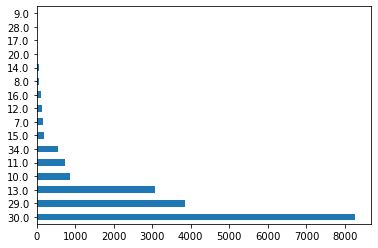

In [43]:
alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 4].value_counts().plot(kind='barh')

In [44]:
print(np.sort(alerts_df['alert_subtype_id'].unique()))

[ 1.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 28.
 29. 30. 31. 32. 33. 34.]


In [45]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 2].unique()))

[1. 2.]


In [46]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 3].unique()))

[3. 4. 5.]


In [47]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 4].unique()))

[ 7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 28. 29. 30. 34.]


In [48]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 7].unique()))

[31. 32. 33.]


I have to assume that 'alert_type_id' is 3 (JAM) and 'alert_subtype_id' 4 is JAM_HEAVY_TRAFFIC and 5 is JAM_STAND_STILL_TRAFFIC

In [49]:
alerts_df['street'].unique().shape

(3140,)

In [50]:
# res_df = alerts_df[:200].apply(lambda row: list(alerts_df['alert_subtype_id'][(alerts_df['street'] == row['street']) & 
#                                                                (alerts_df['publish_date_dt'] <= row['publish_date_dt']) & 
#                                                                (alerts_df['publish_date_dt'] >= row['publish_date_dt'] - pd.Timedelta(minutes=30))])
#                , axis = 1)

In [51]:
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster, asynchronous=True,
                memory_limit='8GB')

ddata = dd.from_pandas(alerts_df, npartitions=36)

alerts_df['seq'] = ddata.map_partitions(lambda df: df.apply((lambda row: list(alerts_df['alert_subtype_id'][(alerts_df['street'] == row['street']) & 
                                                               (alerts_df['publish_date_dt'] < row['publish_date_dt']) & 
                                                               (alerts_df['publish_date_dt'] >= row['publish_date_dt'] - pd.Timedelta('00:30:00'))]))
                                                , axis=1)).compute(scheduler=client)

In [52]:
del ddata

In [53]:
alerts_df.head()

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq
115496,4,7.0,Alberto Llona,2016-08-06 17:55:23+00:00,[]
115542,4,7.0,Manuel Antonio Matta,2017-01-14 15:01:37+00:00,[]
115497,4,7.0,Manuel Antonio Matta,2017-01-14 16:01:37+00:00,[]
115543,4,7.0,Av. Independencia,2017-02-14 12:40:23+00:00,[]
115498,4,7.0,Av. Independencia,2017-02-14 13:40:23+00:00,[]


In [54]:
alerts_df_w_seq = alerts_df[alerts_df.astype(str)['seq'] != '[]'].copy()

In [55]:
alerts_df_w_seq.head()

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq
115494,7,33.0,Av. O'Higgins,2018-02-22 18:55:16+00:00,[33.0]
115508,7,33.0,Av. O'Higgins,2018-02-22 18:55:17+00:00,"[33.0, 33.0]"
115495,7,33.0,Av. O'Higgins,2018-02-22 18:55:18+00:00,"[33.0, 33.0, 33.0]"
115478,7,33.0,Carlos Silva Vildósola,2018-03-05 15:37:45+00:00,[33.0]
27,4,7.0,Autopista Central,2018-04-01 02:54:35+00:00,[3.0]


In [56]:
alerts_df_w_seq.shape

(72528, 5)

In [57]:
alerts_df[(alerts_df['alert_type_id'] == 3) &
          ((alerts_df['alert_subtype_id'] == 4) | (alerts_df['alert_subtype_id'] == 5)) & 
          (alerts_df.astype(str)['seq'] != '[]')].head()

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq
60,3,4.0,Antonia López de Bello,2018-04-01 04:07:34+00:00,[4.0]
78,3,5.0,Antonia López de Bello,2018-04-01 04:56:23+00:00,[4.0]
177,3,5.0,Boulevard Lyon Juana de Arco,2018-04-01 12:06:15+00:00,[30.0]
268,3,4.0,Ruta 78 / Autopista del Sol,2018-04-01 14:10:44+00:00,"[13.0, 13.0, 13.0, 13.0]"
278,3,4.0,Av. Camilo Henríquez,2018-04-01 14:23:36+00:00,[4.0]


In [58]:
alerts_df[(alerts_df['alert_type_id'] == 3) &
          ((alerts_df['alert_subtype_id'] == 4) | (alerts_df['alert_subtype_id'] == 5)) & 
          (alerts_df.astype(str)['seq'] != '[]')].shape

(50779, 5)

In [59]:
alerts_df_w_seq['label'] = np.where((alerts_df_w_seq['alert_type_id'] == 3) &
                                    ((alerts_df_w_seq['alert_subtype_id'] == 4) | (alerts_df_w_seq['alert_subtype_id'] == 5)) &
                                    (alerts_df_w_seq.astype(str)['seq'] != '[]'), 1, 0)

In [60]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 0].head(3)

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq,label
115494,7,33.0,Av. O'Higgins,2018-02-22 18:55:16+00:00,[33.0],0
115508,7,33.0,Av. O'Higgins,2018-02-22 18:55:17+00:00,"[33.0, 33.0]",0
115495,7,33.0,Av. O'Higgins,2018-02-22 18:55:18+00:00,"[33.0, 33.0, 33.0]",0


In [61]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 0].shape

(21749, 6)

In [62]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 1].head(3)

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq,label
60,3,4.0,Antonia López de Bello,2018-04-01 04:07:34+00:00,[4.0],1
78,3,5.0,Antonia López de Bello,2018-04-01 04:56:23+00:00,[4.0],1
177,3,5.0,Boulevard Lyon Juana de Arco,2018-04-01 12:06:15+00:00,[30.0],1


In [63]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 1].shape

(50779, 6)

In [64]:
max_len_event_id = alerts_df_w_seq.seq.apply(len).idxmax()
max_len_event_id

91217

In [65]:
max_len_event = alerts_df_w_seq.loc[max_len_event_id]
print(max_len_event.seq)

[1.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 30.0, 1.0, 30.0, 3.0, 3.0, 5.0, 30.0, 5.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 30.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 3.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 13.0, 4.0, 5.0, 4.0, 5.0, 5.0, 13.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0]


In [66]:
maxlen = len(max_len_event.seq)
maxlen

90

In [69]:
#from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [70]:
sequences = alerts_df_w_seq.seq.tolist()
sequences[:5]

[[33.0], [33.0, 33.0], [33.0, 33.0, 33.0], [33.0], [3.0]]

In [71]:
data = pad_sequences(sequences, maxlen=maxlen)
data

array([[ 0,  0,  0, ...,  0,  0, 33],
       [ 0,  0,  0, ...,  0, 33, 33],
       [ 0,  0,  0, ..., 33, 33, 33],
       ...,
       [ 0,  0,  0, ...,  0,  0, 29],
       [ 0,  0,  0, ...,  0, 29, 29],
       [ 0,  0,  0, ..., 29, 29, 10]], dtype=int32)

In [72]:
labels = np.array(alerts_df_w_seq.label)

In [73]:
np.random.seed(12)

In [74]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [75]:
training_samples = int(len(indices) * .5)
validation_samples = len(indices) - training_samples

In [76]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

In [77]:
X_train

array([[ 0,  0,  0, ..., 30,  1,  3],
       [ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  4,  5,  4],
       ...,
       [ 0,  0,  0, ...,  0,  4, 29],
       [ 0,  0,  0, ...,  3, 30,  5],
       [ 0,  0,  0, ...,  4,  5,  4]], dtype=int32)

In [78]:
num_events = 34 + 1
num_events

35

In [79]:
embedding_dim = 20

In [80]:
embedding_matrix = np.random.rand(num_events, embedding_dim)

To check for gpu run the folowing in terminal:

python

import tensorflow as tf

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

import tensorflow as tf
session = tf.Session()

In [81]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

units = 32 # more implies more complexity, unrelated with

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [82]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          700       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6784      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,517
Trainable params: 6,817
Non-trainable params: 700
_________________________________________________________________


In [84]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("mymodel_embedding_untrainable.h5")

Instructions for updating:
Use tf.cast instead.
Train on 36264 samples, validate on 36264 samples
Epoch 1/5
36264/36264 [==============================] - 88s 2ms/step - loss: 0.5670 - acc: 0.7218 - val_loss: 0.5592 - val_acc: 0.7336
Epoch 2/5
36264/36264 [==============================] - 89s 2ms/step - loss: 0.5521 - acc: 0.7352 - val_loss: 0.5647 - val_acc: 0.7290
Epoch 3/5
36264/36264 [==============================] - 89s 2ms/step - loss: 0.5489 - acc: 0.7378 - val_loss: 0.5520 - val_acc: 0.7397
Epoch 4/5
36264/36264 [==============================] - 89s 2ms/step - loss: 0.5481 - acc: 0.7387 - val_loss: 0.5547 - val_acc: 0.7360
Epoch 5/5
36264/36264 [==============================] - 90s 2ms/step - loss: 0.5469 - acc: 0.7410 - val_loss: 0.5496 - val_acc: 0.7394


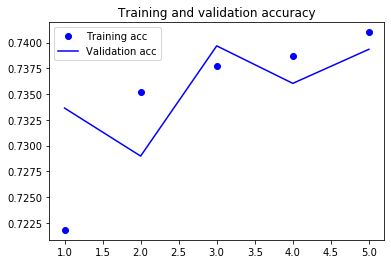

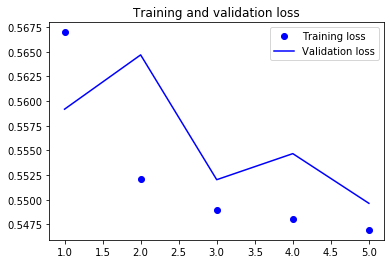

In [85]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

So next step, we can do an experiment to allow the Embedding layer be trained and adjusted.

In [86]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

units = 32

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))

In [87]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [88]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("mymodel_embedding_trainable.h5")

Train on 36264 samples, validate on 36264 samples
Epoch 1/20
36264/36264 [==============================] - 103s 3ms/step - loss: 0.5601 - acc: 0.7288 - val_loss: 0.5590 - val_acc: 0.7293
Epoch 2/20
36264/36264 [==============================] - 103s 3ms/step - loss: 0.5476 - acc: 0.7400 - val_loss: 0.5504 - val_acc: 0.7378
Epoch 3/20
36264/36264 [==============================] - 102s 3ms/step - loss: 0.5459 - acc: 0.7417 - val_loss: 0.5492 - val_acc: 0.7394
Epoch 4/20
36264/36264 [==============================] - 103s 3ms/step - loss: 0.5449 - acc: 0.7420 - val_loss: 0.5505 - val_acc: 0.7386
Epoch 5/20
36264/36264 [==============================] - 104s 3ms/step - loss: 0.5444 - acc: 0.7409 - val_loss: 0.5484 - val_acc: 0.7395
Epoch 6/20
36264/36264 [==============================] - 103s 3ms/step - loss: 0.5438 - acc: 0.7419 - val_loss: 0.5503 - val_acc: 0.7383
Epoch 7/20
36264/36264 [==============================] - 102s 3ms/step - loss: 0.5437 - acc: 0.7421 - val_loss: 0.5521 - 

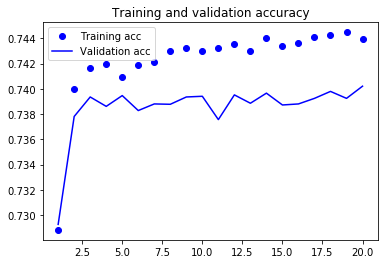

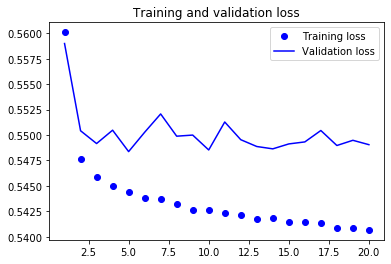

In [89]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()